In [1]:
import xarray as xr
import xarray.ufuncs as xrf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from scipy import stats

In [2]:
alt = [70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, \
       106, 108, 110, 112, 114, 116, 118, 120]
root_path = '/home/gemeinsam_tmp/UA_students/data/'
station = 'Dav'
file = 'Meteor_radar_Dav_GW_201912.h5'
xr.open_dataset( f'{root_path}{station}/{file}', group='info')#['day']
#xr.open_dataset( '/home/gemeinsam_tmp/UA_students/data/Col/Meteor_radar_Col_GW_201903.h5', group='info')['day']

<xarray.Dataset>
Dimensions:  (phony_dim_0: 744, phony_dim_1: 1, phony_dim_2: 26, phony_dim_3: 1)
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2, phony_dim_3
Data variables:
    DOY      (phony_dim_0, phony_dim_1) float64 ...
    alt      (phony_dim_1, phony_dim_2) float64 ...
    day      (phony_dim_0, phony_dim_1) float64 ...
    dh_av    (phony_dim_1, phony_dim_3) float64 ...
    dt       (phony_dim_1, phony_dim_3) float64 ...
    dt_av    (phony_dim_1, phony_dim_3) float64 ...
    hour     (phony_dim_0, phony_dim_1) float64 ...
    min      (phony_dim_0, phony_dim_1) float64 ...
    month    (phony_dim_0, phony_dim_1) float64 ...
    sec      (phony_dim_0, phony_dim_1) float64 ...
    year     (phony_dim_0, phony_dim_1) float64 ...

# Meteor radars

* Dav        Davis; GW:200501-201912
* Col         Collm (Leipzig); GW:200408-201903
* Rio         RioGrande (SAAMER- Argentina); GW:200802-201912
* Sod        Sodankyla; GW:200810-201912
* Kir          Kiruna (Sweden ? Esrange); GW:199908-201912
* CMA      CMOR (Canada ? CMA (CMOR All) triple frequency data); GW:200201-201812
* SES        Sodankyla ? Esrange merged (assigned either to Esrange or Sodankyla or a virtual center in between); GW:199908-201912


Dav_start = '2005-01-'
Dav_end = '2019-12-'
Col_start = '2004-08-01'
Col_end='2019-03-06'
Rio_start = '2008-02-01'
Rio_end = '2019-12-31'
Sod_start = '2008-10-'
Sod_end = '2019-12-'
Kir_start = '1999-08-'
Kir_end = '2019-12-'
Cma_start = '2002-01-01'
Cma_end = '2018-12-31'
Ses_start = '1999-08-'
Ses_end = '2019-12-'


# FUNCTIONS

### lineare regression

In [3]:
def new_linregress(y):
   
    
    mask = ~np.isnan(y)
    #print('y: '+str(y))
    #print('x: '+str(x))
    
    #slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    return np.array([slope, intercept, r_value, p_value, std_err])
    

In [4]:
def new_linregress_masked(y):
   
    
    mask = ~np.isnan(y)
    #print('y: '+str(y))
    #print('x: '+str(x))
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])
    #slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    return np.array([slope, intercept, r_value, p_value, std_err])
    

In [5]:
def time_reg(var):
        #print('var:'+str(var.values))
        statistics = xr.apply_ufunc(new_linregress, var, 
                       input_core_dims=[['time']],
                       output_core_dims=[["parameter"]],
                       vectorize=True,
                       dask="allowed",
                       output_dtypes=['float64'],
                       #output_sizes={"parameter": 5},
                      )
        return statistics

In [6]:
def time_reg_masked(var):
        #print('var:'+str(var.values))
        statistics = xr.apply_ufunc(new_linregress_masked, var, 
                       input_core_dims=[['time']],
                       output_core_dims=[["parameter"]],
                       vectorize=True,
                       dask="allowed",
                       output_dtypes=['float64'],
                       #output_sizes={"parameter": 5},
                      )
        return statistics

In [7]:
def is_mon(month,sta,end):
    return (month >= sta) & (month <= end)

### Variable einlesen

In [8]:
def read_group(gruppe,loc):
    station = loc#ersten Buchstaben bitte bitte groß schreiben
    
    if loc=='Rio':
        timestart = '2008-02-01'
        timeend = '2019-12-31'
    elif loc == 'Col':
        timestart =  '2004-08-01'
        timeend =  '2019-03-06'
    elif loc=='CMA':
        timestart = '2002-01-01'
        timeend = '2018-12-31'    

    elif loc=='Kir':
        timestart = '1999-08-01'
        timeend = '2018-12-31'
        
    elif loc=='Dav':
        timestart = '2005-01-01'
        timeend = '2019-12-31'   
        
        
    infiles = f'{root_path}{station}/Meteor_radar_{station}_GW_*.h5'
    ds = xr.open_mfdataset(infiles, concat_dim = 'phony_dim_6', group = gruppe, combine='nested',parallel = True,chunks= 15)
    ds = ds.rename({'phony_dim_6': 'time', 'phony_dim_7': 'alt'})
    ds['alt'] = alt
    ds['alt'].attrs['units'] = 'km'
    # change time range according to meteor radar station
    ds['time'] = pd.date_range(start = timestart, end = timeend, periods = ds.time.shape[0]) 
    return ds
    
    

In [9]:
def read_var(gruppe, var):
        varout = gruppe[var]
        return varout

### Horizontal Wind

In [10]:
def hwind(u,v):
    return np.sqrt(u**2+v**2)
    

### time mean

In [11]:
def time_mean(step,var):
    return var.resample(time='1'+step).mean('time') #Immer nur D oder M oder H oder Y eintragen! Mit Anführungszeichen!
    
    

### Amomalies

In [12]:
def anomalie(step,var):
    string = "time."+step   
    climatology = var.groupby(string).mean("time")
    anomalies = var.groupby(string) - climatology
    
    return anomalies




## Radar Measurements

In [13]:
ds_radar= read_group('wind','Kir')
u_radar = read_var(ds_radar,'u')  
v_radar = read_var(ds_radar,'v')

u_radar_monano = anomalie('month',u_radar)
v_radar_monano = anomalie('month',v_radar)

u_radar_monthly_ano = time_mean('M',u_radar_monano)
v_radar_monthly_ano = time_mean('M',v_radar_monano)

u_radar_monthly = time_mean('M',u_radar)
v_radar_monthly = time_mean('M',v_radar)

u_radar_yearano = anomalie('month',u_radar)
v_radar_yearano = anomalie('month',v_radar)

u_radar_yearly_ano = time_mean('Y',u_radar_yearano)
v_radar_yearly_ano = time_mean('Y',v_radar_yearano)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


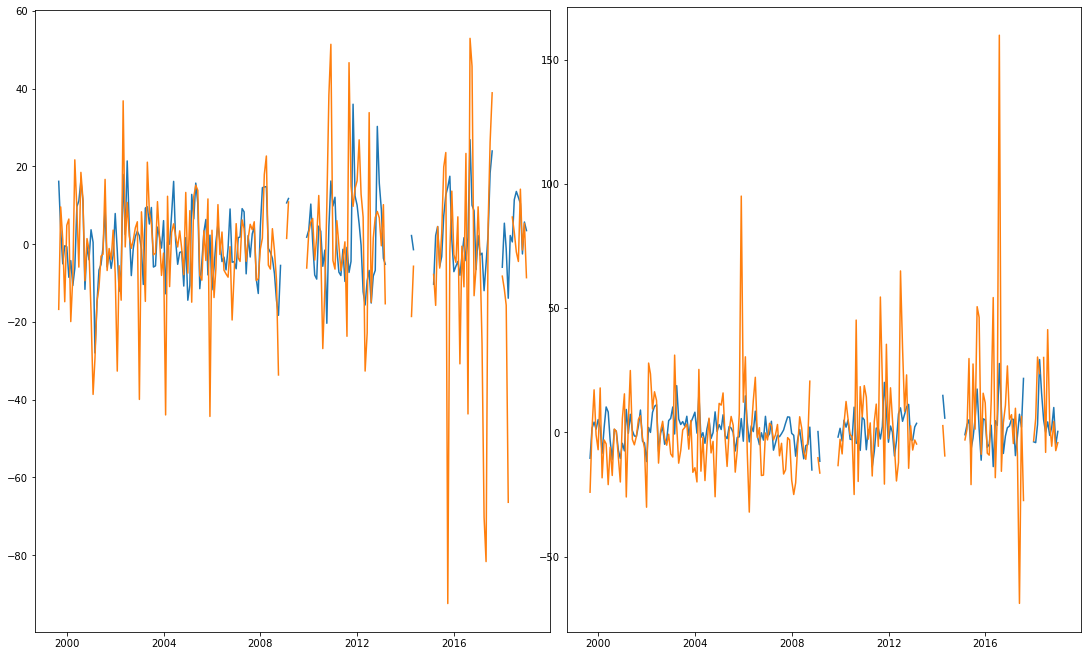

In [14]:
fig = plt.figure(constrained_layout=True,figsize = [15,9])

windsel=u_radar_monthly_ano.sel(alt = [103,108], method = 'nearest')
ax1 = fig.add_subplot(121)
ax1.plot(u_radar_monthly_ano.time,windsel)

windsel=v_radar_monthly_ano.sel(alt = [103,108], method = 'nearest')
ax2 = fig.add_subplot(122)
ax2.plot(u_radar_monthly.time,windsel)


<xarray.DataArray 'u' (time: 233, alt: 26)>
dask.array<stack, shape=(233, 26), dtype=float64, chunksize=(1, 15), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1999-08-31 1999-09-30 ... 2018-12-31
  * alt      (alt) int64 70 72 74 76 78 80 82 84 ... 108 110 112 114 116 118 120


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


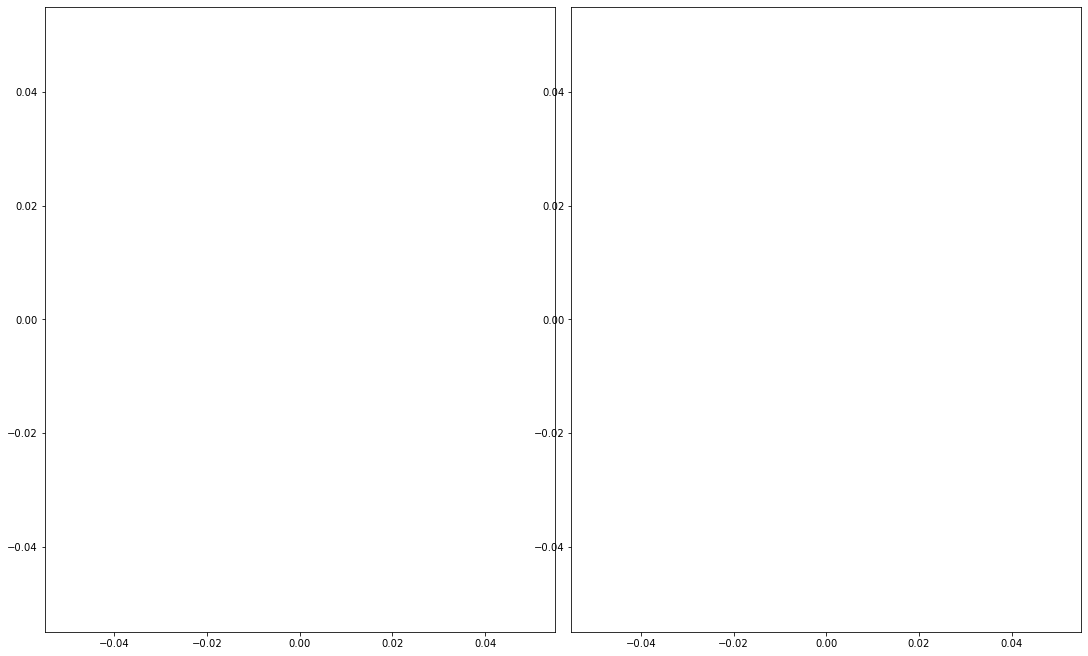

In [15]:
fig = plt.figure(constrained_layout=True,figsize = [15,9])


ax1 = fig.add_subplot(121)
x = np.arange(u_radar_monthly.time.shape[0])
print(u_radar_monthly)
statistics = time_reg(u_radar_monthly)
statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
ax1.plot(u_radar_monthly.alt,statistics.sel(parameter='slope').where(statistics.sel(parameter='p_value')<= 0.05))




ax2 = fig.add_subplot(122)
x = np.arange(v_radar_monthly.time.shape[0])
statistics = time_reg(v_radar_monthly)
statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
ax2.plot(v_radar_monthly.alt,statistics.sel(parameter='slope').where(statistics.sel(parameter='p_value')<= 0.05))

### look at specific months

In [16]:
#Analyse Months seperatly
s = 1
e = 1
u_radar_examon = u_radar_monthly_ano.sel(time=is_mon(u_radar_monthly_ano['time.month'],s,e))
v_radar_examon = v_radar_monthly_ano.sel(time=is_mon(v_radar_monthly_ano['time.month'],s,e))


x = np.arange(u_radar_examon.time.shape[0])


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0, 0.5, 'Slope')

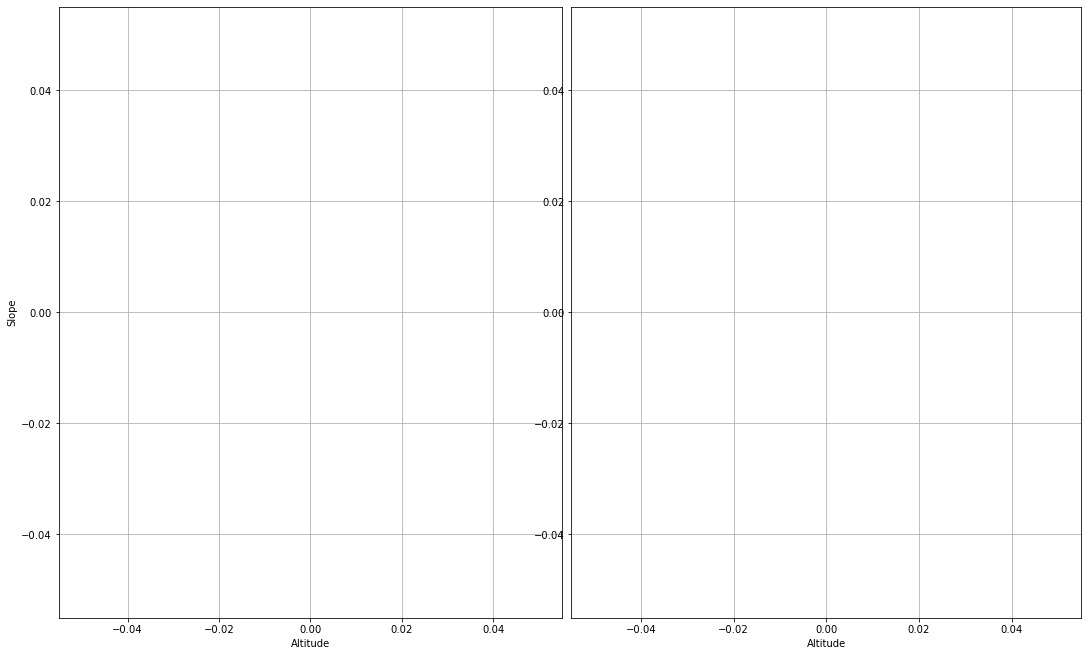

In [17]:
#plot STATISTICS

fig = plt.figure(constrained_layout=True,figsize = [15,9])


ax1 = fig.add_subplot(121)
x = np.arange(np.squeeze(u_radar_examon.time.shape))
#print('ustaexamon: '+str(u_radar_examon))
u_statistics = time_reg(u_radar_examon)
u_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
ax1.plot(u_radar_examon.alt,u_statistics.sel(parameter='slope').where(u_statistics.sel(parameter='p_value')<= 0.05))
ax1.grid()

ax2 = fig.add_subplot(122)
x = np.arange(np.squeeze(v_radar_examon.time.shape))
v_statistics = time_reg(v_radar_examon)
v_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
ax2.plot(v_radar_examon.alt,v_statistics.sel(parameter='slope').where(v_statistics.sel(parameter='p_value')<= 0.05))
ax2.grid()

ax1.set_xlabel('Altitude')
ax2.set_xlabel('Altitude')
ax1.set_ylabel('Slope')



<xarray.DataArray 'u' (alt: 1)>
array([nan])
Coordinates:
  * alt        (alt) int64 90
    parameter  <U9 'slope'


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'v' (alt: 1)>
array([nan])
Coordinates:
  * alt        (alt) int64 98
    parameter  <U9 'slope'


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0, 0.5, 'Monthly averaged wind speed')

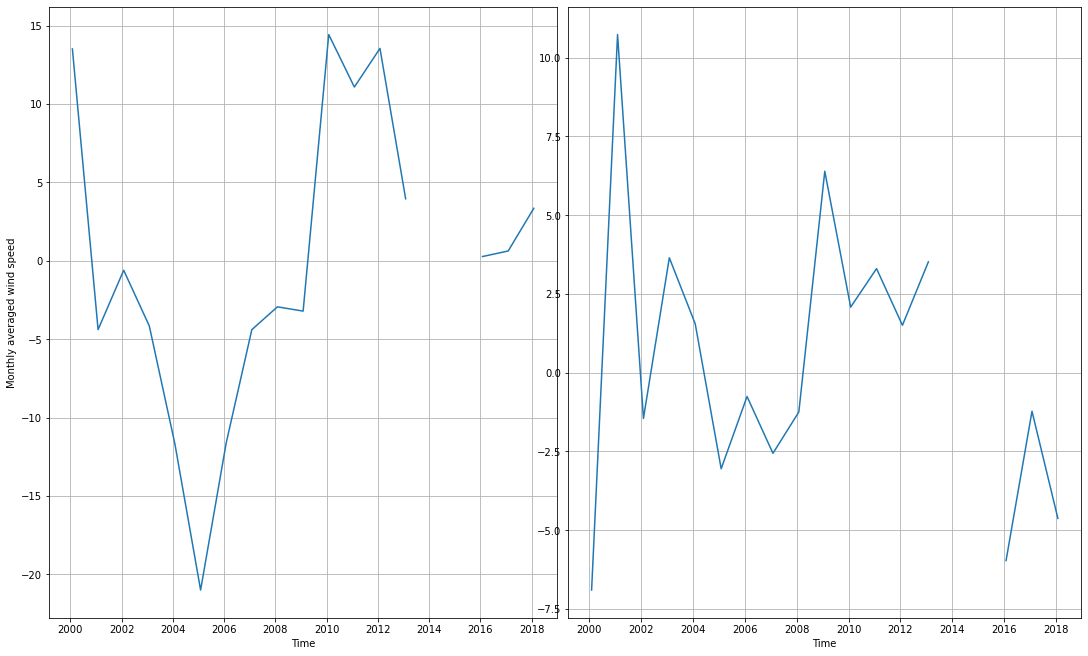

In [18]:
#plot actual DATA

fig = plt.figure(constrained_layout=True,figsize = [15,9])
z = 90
m = (u_statistics.sel(parameter='slope',alt=[z]))
print(m)
n = (u_statistics.sel(parameter='intercept',alt=[z]))
reg = [m*i+n for i in x]

windsel=u_radar_examon.sel(alt = [z], method = 'nearest')
ax1 = fig.add_subplot(121)
ax1.plot(u_radar_examon.time,windsel)
ax1.plot(u_radar_examon.time,reg)

ax1.grid()

z = 98
m = (v_statistics.sel(parameter='slope',alt=[z]))
print(m)
n = (v_statistics.sel(parameter='intercept',alt=[z]))
reg = [m*i+n for i in x]
windsel=v_radar_examon.sel(alt = [z], method = 'nearest')
ax2 = fig.add_subplot(122)
ax2.plot(v_radar_examon.time,windsel)
ax2.plot(u_radar_examon.time,reg)
ax2.grid()


ax1.set_xlabel('Time')
ax2.set_xlabel('Time')
ax1.set_ylabel('Monthly averaged wind speed')


# GAIA

## Functions for GAIA

In [19]:
root_path = '/home/gemeinsam_tmp/UA_students/data/'
fname = ''

In [20]:
def read_gaia_group(gruppe,loc):
   
    if loc=='Rio':
        timestart = '2008-02-01'
        timeend = '2019-12-31'
        fname = 'GAIA_Rio_20080201_20141231_run20200603.nc'
    
    elif loc == 'Col':
        timestart =  '2004-08-01'
        timeend =  '2017-12-31'
        fname= 'GAIA_Col_20040801_20171231_run20200604.nc'
    
    elif loc=='CMA':
        timestart = '2002-01-01'
        timeend = '2018-12-31'
        fname = 'GAIA_CMA_20020101_20171231_run20200531.nc'
        
    infile = f'{root_path}{fname}'
    ds = xr.open_dataset(infile, group=gruppe, chunks=15)
    ds['time'] = pd.date_range(start = timestart, end = timeend, periods=ds.time.shape[0])
    
    return ds

## Gaia Simulations

In [21]:
ds = read_gaia_group('GAIA','Kir')
ds
u_gaia = ds.u0
v_gaia = ds.v0

print('I reach this line...')
u_gaia_monano = anomalie('month',u_gaia)
print('...But not this one')
v_gaia_monano = anomalie('month',v_gaia)

u_gaia_monthly_ano = time_mean('M',u_gaia_monano)
v_gaia_monthly_ano = time_mean('M',v_gaia_monano)

u_gaia_monthly = time_mean('M',u_gaia)
v_gaia_monthly = time_mean('M',v_gaia)


OSError: [Errno -51] NetCDF: Unknown file format: b'/home/gemeinsam_tmp/UA_students/data'

In [ ]:
fig = plt.figure(constrained_layout=True,figsize = [15,9])

x = np.arange(u_gaia_monthly_ano.time.shape[0])
ax1 = fig.add_subplot(121)
u_statistics = time_reg(u_gaia_monthly_ano)
u_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
ax1.plot(u_gaia_monthly.alt,u_statistics.sel(parameter='slope').where(u_statistics.sel(parameter='p_value')<= 0.05))
ax1.grid()

x = np.arange(v_gaia_monthly_ano.time.shape[0])
ax2 = fig.add_subplot(122)
v_statistics = time_reg(v_gaia_monthly_ano)
v_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
ax2.plot(v_gaia_monthly.alt,v_statistics.sel(parameter='slope').where(v_statistics.sel(parameter='p_value')<= 0.05))
ax2.grid()


In [ ]:
fig = plt.figure(constrained_layout=True,figsize = [15,9])

windsel=u_gaia_monthly_ano.sel(alt = [100,110], method = 'nearest')
ax1 = fig.add_subplot(121)
ax1.plot(u_gaia_monthly_ano.time,windsel)

windsel=v_gaia_monthly_ano.sel(alt = [100,110], method = 'nearest')
ax2 = fig.add_subplot(122)
ax2.plot(v_gaia_monthly_ano.time,windsel)


### Analyzing specific months from GAIA-COLLM

In [ ]:
#Analyse Months seperatly
s = 1
e = 1
u_gaia_examon = u_gaia_monthly_ano.sel(time=is_mon(u_gaia_monthly_ano['time.month'],s,e))
v_gaia_examon = v_gaia_monthly_ano.sel(time=is_mon(v_gaia_monthly_ano['time.month'],s,e))


x = np.arange(u_gaia_examon.time.shape[0])

In [ ]:
fig = plt.figure(constrained_layout=True,figsize = [15,9])


ax1 = fig.add_subplot(121)
x = np.arange(np.squeeze(u_gaia_examon.time.shape))
#print('ucol_gaiaexamon: '+str(u_gaia_examon))
u_statistics_gaia = time_reg(u_gaia_examon)
u_statistics_gaia['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
ax1.plot(u_gaia_examon.alt,u_statistics_gaia.sel(parameter='slope').where(u_statistics_gaia.sel(parameter='p_value')<= 0.05))
ax1.grid()


ax2 = fig.add_subplot(122)
x = np.arange(np.squeeze(v_gaia_examon.time.shape))
v_statistics_gaia = time_reg(v_gaia_examon)
v_statistics_gaia['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
ax2.plot(v_gaia_examon.alt,v_statistics_gaia.sel(parameter='slope').where(v_statistics_gaia.sel(parameter='p_value')<= 0.05))
ax2.grid()

ax1.set_xlabel('Altitude')
ax2.set_xlabel('Altitude')
ax1.set_ylabel('Slope')
plt.savefig('test.png', bbox_inches='tight')

In [ ]:
#plot actual DATA

fig = plt.figure(constrained_layout=True,figsize = [15,9])
z = 100
m_gaia = (u_statistics_gaia.sel(parameter='slope',alt=[z]))
print(m)
n_gaia = (u_statistics_gaia.sel(parameter='intercept',alt=[z]))
reg_gaia = [m_gaia*i+n_gaia for i in x]

windsel_gaia=u_gaia_examon.sel(alt = [z], method = 'nearest')
ax1 = fig.add_subplot(121)
ax1.plot(u_gaia_examon.time,windsel_gaia)
ax1.plot(u_gaia_examon.time,reg_gaia)

ax1.grid()

z = 100
m_gaia = (v_statistics_gaia.sel(parameter='slope',alt=[z]))

n_gaia = (v_statistics_gaia.sel(parameter='intercept',alt=[z]))
reg_gaia = [m_gaia*i+n_gaia for i in x]
windsel_gaia=v_gaia_examon.sel(alt = [z], method = 'nearest')
ax2 = fig.add_subplot(122)
ax2.plot(v_gaia_examon.time,windsel_gaia)
ax2.plot(u_gaia_examon.time,reg_gaia)
ax2.grid()

ax1.set_xlabel('Time')
ax2.set_xlabel('Time')
ax1.set_ylabel('Monthly averaged wind speed')


## Plotting Radar + Gaia Measurements

### u

In [ ]:

s = 2
e = 2
z = 106

u_radar_examon = u_radar_monthly_ano.sel(time=is_mon(u_radar_monthly_ano['time.month'],s,e))
u_gaia_examon = u_gaia_monthly_ano.sel(time=is_mon(u_gaia_monthly_ano['time.month'],s,e))

x_gaia = np.arange(u_gaia_examon.time.shape[0])
x = np.arange(u_radar_examon.time.shape[0])

u_statistics_gaia = time_reg(u_gaia_examon)
u_statistics_gaia['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
u_statistics = time_reg(u_radar_examon)
u_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']

m = (u_statistics.sel(parameter='slope',alt=[z]))
n = (u_statistics.sel(parameter='intercept',alt=[z]))
m_gaia = (u_statistics_gaia.sel(parameter='slope',alt=[z]))
n_gaia = (u_statistics_gaia.sel(parameter='intercept',alt=[z]))

reg = [m*i+n for i in x]
reg_gaia = [m_gaia*i+n_gaia for i in x]




In [ ]:
pvradar = 6
plotstring = '\n'.join((
    r'P Values: ',
    r'Radar   '+ str(round(*u_statistics.sel(parameter='p_value',alt=[z]).values,3 )),
    r'Gaia    '+ str(round(*u_statistics_gaia.sel(parameter = 'p_value',alt=[z]).values,3 ))))
print(plotstring)

In [ ]:
fig = plt.figure(constrained_layout=True,figsize = [15,9])

windsel_gaia = u_gaia_examon.sel(alt = [z], method = 'nearest')
windsel_radar = u_radar_examon.sel(alt = [z], method = 'nearest')

ax1 = fig.add_subplot(111)
ax1.plot(u_radar_examon.time,windsel_radar, label = 'Radar')
ax1.plot(u_radar_examon.time,reg)
ax1.plot(u_gaia_examon.time,windsel_gaia, label = 'Gaia')
ax1.plot(u_gaia_examon.time,reg_gaia)

ax1.grid()
ax1.set_xlabel('Time')
ax1.set_ylabel('Monthly averaged wind speed')
ax1.legend()
ax1.text(.9,0.01,plotstring, transform=ax1.transAxes)

### v  

In [ ]:

s = 2
e = 2
z = 106

v_radar_examon = v_radar_monthly_ano.sel(time=is_mon(v_radar_monthly_ano['time.month'],s,e))
v_gaia_examon = v_gaia_monthly_ano.sel(time=is_mon(v_gaia_monthly_ano['time.month'],s,e))

x_gaia = np.arange(v_gaia_examon.time.shape[0])
x = np.arange(v_radar_examon.time.shape[0])

v_statistics_gaia = time_reg(v_gaia_examon)
v_statistics_gaia['parameter'] = ['slope', 'intercept', 'r_valve','p_value', 'std_err']
v_statistics = time_reg(v_radar_examon)
v_statistics['parameter'] = ['slope', 'intercept', 'r_valve','p_value', 'std_err']

m = (v_statistics.sel(parameter='slope',alt=[z]))
n = (v_statistics.sel(parameter='intercept',alt=[z]))
m_gaia = (v_statistics_gaia.sel(parameter='slope',alt=[z]))
n_gaia = (v_statistics_gaia.sel(parameter='intercept',alt=[z]))

reg = [m*i+n for i in x]
reg_gaia = [m_gaia*i+n_gaia for i in x]



In [ ]:

plotstring = '\n'.join((
    r'P Values: ',
    r'Radar   '+ str(round(*v_statistics.sel(parameter='p_value',alt=[z]).values,3 )),
    r'Gaia    '+ str(round(*v_statistics_gaia.sel(parameter = 'p_value',alt=[z]).values,3 ))))
print(plotstring)

In [ ]:
fig = plt.figure(constrained_layout=True,figsize = [15,9])

windsel_gaia = v_gaia_examon.sel(alt = [z], method = 'nearest')
windsel_radar = v_radar_examon.sel(alt = [z], method = 'nearest')

ax1 = fig.add_subplot(111)
ax1.plot(v_radar_examon.time,windsel_radar, label = 'Radar')
ax1.plot(v_radar_examon.time,reg)
ax1.plot(v_gaia_examon.time,windsel_gaia, label = 'Gaia')
ax1.plot(v_gaia_examon.time,reg_gaia)

ax1.grid()
ax1.set_xlabel('Time')
ax1.set_ylabel('Monthly averaged wind speed')
ax1.legend()
ax1.text(.9,0.01,plotstring, transform=ax1.transAxes)